In this notebook we try to practice all the classification algorithms that we learned in this course.

We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Lets first load required libraries:

In [10]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

# About dataset

This dataset is about past loans. The __Loan_train.csv__ data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |

In [11]:
!wget -O loan_train.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv

--2020-07-02 09:43:29--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

100%[======================================>] 23,101      --.-K/s   in 0.002s  

2020-07-02 09:43:29 (12.4 MB/s) - ‘loan_train.csv’ saved [23101/23101]



### Load Data From CSV File  

In [12]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


# Data visualization and pre-processing


In [13]:
print(df['loan_status'].value_counts())
print(df['education'].value_counts())
print(df['Gender'].value_counts())

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64
High School or Below    151
college                 149
Bechalor                 44
Master or Above           2
Name: education, dtype: int64
male      294
female     52
Name: Gender, dtype: int64


260 people have paid off the loan on time while 86 have gone into collection
male 294 and female 52 
among them 151 are high school or below, 149 are college students and 2 ar master or above

### Convert to date time object 

In [14]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])

# Pre-processing:  Feature selection/extraction

### Lets look at the day of the week people get the loan 

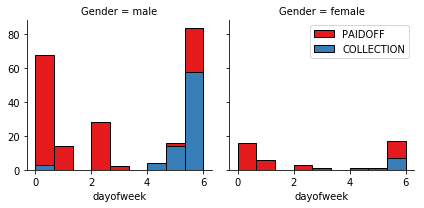

In [15]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()

We see that people who get the loan at the end of the week dont pay it off, so lets use Feature binarization to set a threshold values less then day 4 

In [16]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convert Categorical features to numerical values

In [17]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan

Lets convert male to 0 and female to 1:

In [18]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()


,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


## One Hot Encoding  
#### How about education?

In [19]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


In [20]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


#### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame 

### Feature selection

In [21]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


In [22]:
y = df['loan_status'].values
y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

## Normalize Data 

In [23]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:1: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  if __name__ == '__main__':


array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679]])

# Classification 

Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:
- K Nearest Neighbor(KNN)
- Decision Tree
- Support Vector Machine
- Logistic Regression



__ Notice:__ 
- You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
- You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
- You should include the code of the algorithm in the following cells.

## Question 1 Building model using KNN, finding the best k and accuracy evaluation (7 marks)

- Anwers
- part1
 - Below Code results perform the KNN using Sickit-learn.
   - Train set Accuracy:  0.8115942028985508
   - Test set Accuracy:  0.6857142857142857
- part2
  - Best K we can observe in the graph is 7, So best K = 7 
- part3 
  - The best accuracy was with 0.7857142857142857 with k= 7

In [27]:
#KNN

from sklearn.model_selection import train_test_split
X_traink, X_testk, y_traink, y_testk = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Train set:', X_traink.shape,  y_traink.shape)
print ('Test set:', X_testk.shape,  y_testk.shape)

from sklearn.neighbors import KNeighborsClassifier
k = 4
#Train Model and Predict  
neigh = KNeighborsClassifier(n_neighbors = k).fit(X_traink,y_traink)
neigh
yhatk = neigh.predict(X_testk)

from sklearn import metrics
print("Train set Accuracy: ", metrics.accuracy_score(y_traink, neigh.predict(X_traink)))
print("Test set Accuracy: ", metrics.accuracy_score(y_testk, yhatk))


Train set: (276, 8) (276,)
Test set: (70, 8) (70,)
Train set Accuracy:  0.8152173913043478
Test set Accuracy:  0.6857142857142857


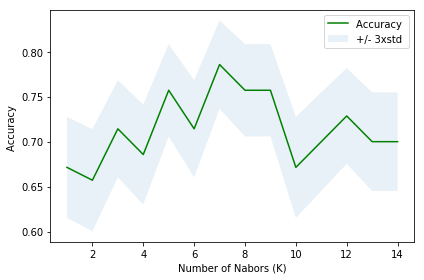

In [28]:
#Finding the best value of k
Ks = 15
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))
ConfustionMx = [];
for n in range(1,Ks):
    
    #Train Model and Predict  
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_traink,y_traink)
    yhatk=neigh.predict(X_testk)
    mean_acc[n-1] = metrics.accuracy_score(y_testk, yhatk)

    
    std_acc[n-1]=np.std(yhatk==y_testk)/np.sqrt(yhatk.shape[0])

plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Nabors (K)')
plt.tight_layout()
plt.show()

In [29]:
print( "The best accuracy was with", mean_acc.max(), "with k=", mean_acc.argmax()+1) 

The best accuracy was with 0.7857142857142857 with k= 7


In [31]:
k = 13
#Train Model and Predict  
neighf = KNeighborsClassifier(n_neighbors = k).fit(X_traink,y_traink)
neighf
yhat2k = neighf.predict(X_testk)
yhat2k



array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'COLLECTION', 'COLLECTION', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'COLLECTION', 'PAIDOFF', 'COLLECTION', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'COLLECTION', 'PAIDOFF', 'PAIDOFF', 'COLLECTION',
       'COLLECTION', 'PAIDOFF', 'COLLECTION', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'COLLECTION', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'COLLECTION',
       'PAIDOFF', 'PAIDOFF', 'COLLECTION', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'COLLECTION', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF'], dtype=object)

In [33]:
# Building the model again, using k=7
from sklearn.neighbors import KNeighborsClassifier
k = 7
#Train Model and Predict  
kNN_model = KNeighborsClassifier(n_neighbors=k).fit(X_traink,y_traink)
kNN_model

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=7, p=2,
           weights='uniform')

# Decision Tree

# #Question 2: Building model using Decision Tree, finding the best k and accuracy evaluation (6 marks)



- Anwers
- part1
 - Below Code results perform the decision tree using Sickit-learn.
   - DecisionTrees's Accuracy:  0.6634615384615384
- part2
  - Best K we can observe depth is 4, So best K = 4 
- part3 
  - The best accuracy DecisionTrees's Accuracy:  0.6826923076923077 and depth with k= 4

In [35]:
#decession tree
from sklearn.model_selection import train_test_split
X_trainsetd, X_testsetd, y_trainsetd, y_testsetd = train_test_split(X, y, test_size=0.3, random_state=3)
from sklearn.tree import DecisionTreeClassifier
decTree = DecisionTreeClassifier(criterion="entropy",max_depth=10)
decTree.fit(X_trainsetd,y_trainsetd)
predTree = decTree.predict(X_testsetd)
from sklearn import metrics
import matplotlib.pyplot as plt
print("DecisionTrees's Accuracy: ", metrics.accuracy_score(y_testsetd, predTree))

DecisionTrees's Accuracy:  0.6442307692307693


In [36]:
from sklearn import decomposition, datasets
from sklearn import tree
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
# Create a pca object
pca = decomposition.PCA()

# Create a logistic regression object with an L2 penalty
decisiontree = tree.DecisionTreeClassifier()

#create a pipeline of three steps. First, standardize the data.
# Second, tranform the data with PCA.
# Third, train a Decision Tree Classifier on the data.
pipe = Pipeline(steps=[('pca', pca),('decisiontree', decisiontree)])

# Create Parameter Space
# Create a list of a sequence of integers from 1 to 30 (the number of features in X + 1)
n_components = list(range(1,X.shape[1]+1,1))

# Create lists of parameter for Decision Tree Classifier
criterion = ['gini', 'entropy']
max_depth = [4,6,8,12]

# Create a dictionary of all the parameter options 
# Note has you can access the parameters of steps of a pipeline by using '__’
parameters = dict(pca__n_components=n_components,decisiontree__criterion=criterion,decisiontree__max_depth=max_depth)

# Conduct Parameter Optmization With Pipeline
# Create a grid search object
decTreef = GridSearchCV(pipe, parameters)

# Fit the grid search
decTreef.fit(X_trainsetd,y_trainsetd)

# View The Best Parameters
print('Best Criterion:', decTreef.best_estimator_.get_params()['decisiontree__criterion'])
print('Best max_depth:', decTreef.best_estimator_.get_params()['decisiontree__max_depth'])
print('Best Number Of Components:', decTreef.best_estimator_.get_params()['pca__n_components'])
print(); print(decTreef.best_estimator_.get_params()['decisiontree'])

decTreeff = DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,max_features=None, max_leaf_nodes=None,min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
decTreeff.fit(X_trainsetd,y_trainsetd)
print("DecisionTrees's Accuracy: ", metrics.accuracy_score(y_testsetd, decTreeff.predict(X_testsetd)))

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Best Criterion: gini
Best max_depth: 4
Best Number Of Components: 1

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
DecisionTrees's Accuracy:  0.6826923076923077


/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [38]:
!conda install -c conda-forge pydotplus -y
!conda install -c conda-forge python-graphviz -y

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - pydotplus


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    certifi-2020.6.20          |   py36h9f0ad1d_0         151 KB  conda-forge
    openssl-1.1.1g             |       h516909a_0         2.1 MB  conda-forge
    python_abi-3.6             |          1_cp36m           4 KB  conda-forge
    ca-certificates-2020.6.20  |       hecda079_0         145 KB  conda-forge
    pydotplus-2.0.2            |     pyhd1c1de3_3          23 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.4 MB

The following NEW packages will be INSTALLED:

    pydotplus:       2.0.2-pyhd1c1de3_3 conda-forge
    python_abi:      3.6-1_cp36m        conda-forge

The following packages will be UPDATED:

 

In [37]:
from sklearn.externals.six import StringIO
import pydotplus
import matplotlib.image as mpimg
from sklearn import tree
%matplotlib inline 

dot_data = StringIO()
filename = "Tree.png"
featureNames = my_data.columns[0:5]
targetNames = my_data["Loan"].unique().tolist()
out=tree.export_graphviz(drugTree,feature_names=featureNames, out_file=dot_data, class_names= np.unique(y_trainset), filled=True,  special_characters=True,rotate=False)  
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png(filename)
img = mpimg.imread(filename)
plt.figure(figsize=(100, 200))
plt.imshow(img,interpolation='nearest')

ModuleNotFoundError: No module named 'pydotplus'

# Support Vector Machine


## Question 3 : Building model using SVM, finding the best k and accuracy evaluation (6 marks)
- Anwers
- part1
 - Below Code results perform the SVM using Sickit-learn. Model Accurracy 
   - f1 score 0.7275882012724117
   - jaccard score 0.7428571428571429


In [47]:
#SVM

X_trains, X_tests, y_trains, y_tests = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Train set:', X_trains.shape,  y_trains.shape)
print ('Test set:', X_tests.shape,  y_tests.shape)


from sklearn import svm
from sklearn.svm import SVC
clf = svm.SVC(kernel='rbf')
clf.fit(X_trains, y_trains) 
yhats = clf.predict(X_tests)
yhats

Train set: (276, 8) (276,)
Test set: (70, 8) (70,)


/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


array(['COLLECTION', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'COLLECTION', 'COLLECTION', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'COLLECTION', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'COLLECTION', 'COLLECTION', 'PAIDOFF', 'COLLECTION',
       'COLLECTION', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'COLLECTION', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'COLLECTION', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'COLLECTION',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

In [44]:


from sklearn.metrics import f1_score
print("f1 score",f1_score(y_tests, yhats, average='weighted') )

from sklearn.metrics import jaccard_similarity_score
print("jaccard score",jaccard_similarity_score(y_tests, yhats))

from sklearn.model_selection import GridSearchCV
param_grid = {'C': [0.01,0.1,1, 10, 100], 'gamma': [10,1,0.1,0.01],'kernel': ['rbf', 'linear', 'sigmoid']}
grid = GridSearchCV(SVC(),param_grid,refit=True,verbose=2)

f1 score 0.7275882012724117
jaccard score 0.7428571428571429


/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [31]:
grid.fit(X_trains,y_trains)


/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Fitting 3 folds for each of 60 candidates, totalling 180 fits
[CV] C=0.01, gamma=10, kernel=rbf ....................................
[CV] ..................... C=0.01, gamma=10, kernel=rbf, total=   0.0s
[CV] C=0.01, gamma=10, kernel=rbf ....................................
[CV] ..................... C=0.01, gamma=10, kernel=rbf, total=   0.0s
[CV] C=0.01, gamma=10, kernel=rbf ....................................
[CV] ..................... C=0.01, gamma=10, kernel=rbf, total=   0.0s
[CV] C=0.01, gamma=10, kernel=linear .................................
[CV] .................. C=0.01, gamma=10, kernel=linear, total=   0.0s
[CV] C=0.01, gamma=10, kernel=linear .................................
[CV] .................. C=0.01, gamma=10, kernel=linear, total=   0.0s
[CV] C=0.01, gamma=10, kernel=linear .................................
[CV] .................. C=0.01, gamma=10, kernel=linear, total=   0.0s
[CV] C=0.01, gamma=10, kernel=sigmoid ................................
[CV] ..........

[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed:    1.0s finished
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [32]:
print("Avg F1-score: %.4f" % f1_score(y_tests,grid.predict(X_tests), average='weighted'))
print("Jaccard score: %.4f" % jaccard_similarity_score(y_tests,grid.predict(X_tests)))

Avg F1-score: 0.6973
Jaccard score: 0.7143


In [33]:
clf2 = svm.SVC(C=0.1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=1, kernel='sigmoid',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
clf2.fit(X_trains, y_trains) 
yhat2s = clf2.predict(X_tests)
print("Avg F1-score: %.4f" % f1_score(y_tests, yhat2s, average='weighted'))
print("Jaccard score: %.4f" % jaccard_similarity_score(y_tests, yhat2s))

Avg F1-score: 0.6973
Jaccard score: 0.7143


# Logistic Regression


## Building model using Logistic Regression, finding the best k and accuracy evaluation (6 marks)
  - LogLoss: : 0.49
  - k = 0.1
  - best k = 0.1 leads to 0.49 loss 


In [52]:
## logistic regression

X_trainl, X_testl, y_trainl, y_testl = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Train set:', X_trainl.shape,  y_trainl.shape)
print ('Test set:', X_testl.shape,  y_testl.shape)

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
LR = LogisticRegression(C=0.1, solver='liblinear').fit(X_trainl,y_trainl)
yhatl = LR.predict(X_testl)

yhat_prob = LR.predict_proba(X_testl)
#yhat_prob

Train set: (276, 8) (276,)
Test set: (70, 8) (70,)


In [35]:
from sklearn.metrics import log_loss
print("Avg F1-score: %.4f" % f1_score(y_testl, yhatl, average='weighted'))
print("Jaccard score: %.4f" % jaccard_similarity_score(y_testl, yhatl))
print ("LogLoss: : %.2f" % log_loss(y_testl, yhat_prob))

Avg F1-score: 0.7048
Jaccard score: 0.7429
LogLoss: : 0.50


In [37]:
grid={"C":np.logspace(-3,3,7), "solver":["liblinear","sag","newton-cg","lbfgs"]}
LRf=GridSearchCV(LogisticRegression(),grid,cv=10)


In [38]:
f=GridSearchCV(LogisticRegression(),grid,cv=10)
LRf.fit(X_trainl,y_trainl)
print("tuned hpyerparameters :(best parameters) ",LRf.best_params_)
print("Avg F1-score: %.4f" % f1_score(y_testl, LRf.predict(X_testl), average='weighted'))
print("Jaccard score: %.4f" % jaccard_similarity_score(y_testl, LRf.predict(X_testl)))
print ("LogLoss: : %.2f" % log_loss(y_testl, LRf.predict_proba(X_testl)))

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The ma

tuned hpyerparameters :(best parameters)  {'C': 0.1, 'solver': 'liblinear'}
Avg F1-score: 0.7048
Jaccard score: 0.7429
LogLoss: : 0.50


/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [63]:
LR2 = LogisticRegression(C=0.01, solver='sag').fit(X_trainl,y_trainl)
yhat_prob2 = LR2.predict_proba(X_testl)
print ("LogLoss: : %.2f" % log_loss(y_testl, yhat_prob2))

LogLoss: : 0.49


In [64]:
LR2 = LogisticRegression(C=0.01, solver='sag').fit(X_trainl,y_trainl)
yhat_prob3 = LR2.predict_proba(X_testl)
print ("LogLoss: : %.2f" % log_loss(y_testl, yhat_prob3))

LogLoss: : 0.49


In [65]:
LR2 = LogisticRegression(C=0.01, solver='sag').fit(X_trainl,y_trainl)
yhat_prob4 = LR2.predict_proba(X_testl)
print ("LogLoss: : %.2f" % log_loss(y_testl, yhat_prob4))

LogLoss: : 0.49


# Model Evaluation using Test set

In [54]:
### MODEL EVAL

from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

First, download and load the test set:

In [53]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

--2020-07-02 10:39:31--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3.6K) [text/csv]
Saving to: ‘loan_test.csv’

100%[======================================>] 3,642       --.-K/s   in 0s      

2020-07-02 10:39:31 (390 MB/s) - ‘loan_test.csv’ saved [3642/3642]



In [55]:
test_df = pd.read_csv('loan_test.csv')

In [56]:
test_df['due_date'] = pd.to_datetime(test_df['due_date'])
test_df['effective_date'] = pd.to_datetime(test_df['effective_date'])

test_df['dayofweek'] = test_df['effective_date'].dt.dayofweek
test_df['weekend'] = test_df['dayofweek'].apply(lambda x: 1 if (x>4)  else 0)
test_df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)

In [57]:
Feature = test_df[['Principal','age','Gender','terms','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(test_df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)

In [58]:
X_t = Feature
y_t = test_df['loan_status'].values
X_t= preprocessing.StandardScaler().fit(X_t).transform(X_t)

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:3: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  app.launch_new_instance()


In [70]:
test_y = test_df['loan_status'].values
test_y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

In [72]:
knnf=f1_score(y_t,neighf.predict(X_t), average='weighted')
knnj=jaccard_similarity_score(y_t,neighf.predict(X_t))

In [73]:
dtf=f1_score(y_t, decTreeff.predict(X_t), average='weighted')
dtj=jaccard_similarity_score(y_t, decTreeff.predict(X_t))

In [74]:
svmf=f1_score(y_t, clf.predict(X_t), average='weighted')
svmj=jaccard_similarity_score(y_t, clf.predict(X_t))

In [75]:
lrf=f1_score(y_t, LR2.predict(X_t), average='weighted',labels=np.unique(LR2.predict(X_t)))
lrj=jaccard_similarity_score(y_t, LR2.predict(X_t))

In [76]:
lrll=log_loss(y_t, LR2.predict_proba(X_t))

In [77]:
LR_yhat = LR2.predict(X_t)
LR_yhat_prob = LR2.predict_proba(X_t)
print("LR Jaccard index: %.2f" % jaccard_similarity_score(test_y, LR_yhat))
print("LR F1-score: %.2f" % f1_score(test_y, LR_yhat, average='weighted') )
print("LR LogLoss: %.2f" % log_loss(test_y, LR_yhat_prob))

LR Jaccard index: 0.74
LR F1-score: 0.63
LR LogLoss: 0.54


/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


| Algorithm          | Jaccard | F1-score | LogLoss |
|--------------------|---------|----------|---------|
| KNN                | 0.67    | 0.63     | NA      |
| Decision Tree      | 0.72    | 0.74     | NA      |
| SVM                | 0.80    | 0.76     | NA      |
| LogisticRegression | 0.74    | 0.63     | 0.54  |